In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from multiprocessing import *
import gc
import warnings
warnings.filterwarnings("ignore")

import xgboost as xgb

#######################################

# Thanks Pascal and the1owl 

# Pascal's Recovery https://www.kaggle.com/pnagel/reconstruction-of-ps-reg-03
# Froza's Baseline https://www.kaggle.com/the1owl/forza-baseline

# single XGB LB 0.285 will release soon.

#######################################

In [2]:
#### Load Data
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

In [3]:
### 
y = train['target'].values
testid= test['id'].values

train.drop(['id','target'],axis=1,inplace=True)
test.drop(['id'],axis=1,inplace=True)

### Drop calc
unwanted = train.columns[train.columns.str.startswith('ps_calc_')]
train = train.drop(unwanted, axis=1)  
test = test.drop(unwanted, axis=1)

### Great Recovery from Pascal's materpiece
### Great Recovery from Pascal's materpiece
### Great Recovery from Pascal's materpiece
### Great Recovery from Pascal's materpiece
### Great Recovery from Pascal's materpiece

def recon(reg):
    integer = int(np.round((40*reg)**2)) 
    for a in range(32):
        if (integer - a) % 31 == 0:
            A = a
    M = (integer - A)//31
    return A, M
train['ps_reg_A'] = train['ps_reg_03'].apply(lambda x: recon(x)[0])
train['ps_reg_M'] = train['ps_reg_03'].apply(lambda x: recon(x)[1])
train['ps_reg_A'].replace(19,-1, inplace=True)
train['ps_reg_M'].replace(51,-1, inplace=True)
test['ps_reg_A'] = test['ps_reg_03'].apply(lambda x: recon(x)[0])
test['ps_reg_M'] = test['ps_reg_03'].apply(lambda x: recon(x)[1])
test['ps_reg_A'].replace(19,-1, inplace=True)
test['ps_reg_M'].replace(51,-1, inplace=True)


### Froza's baseline
### Froza's baseline
### Froza's baseline
### Froza's baseline

d_median = train.median(axis=0)
d_mean = train.mean(axis=0)
d_skew = train.skew(axis=0)
one_hot = {c: list(train[c].unique()) for c in train.columns if c not in ['id','target']}

def transform_df(df):
    df = pd.DataFrame(df)
    dcol = [c for c in df.columns if c not in ['id','target']]
    df['ps_car_13_x_ps_reg_03'] = df['ps_car_13'] * df['ps_reg_03']
    df['negative_one_vals'] = np.sum((df[dcol]==-1).values, axis=1)
    for c in dcol:
        if '_bin' not in c: #standard arithmetic
            df[c+str('_median_range')] = (df[c].values > d_median[c]).astype(np.int)
            df[c+str('_mean_range')] = (df[c].values > d_mean[c]).astype(np.int)

    for c in one_hot:
        if len(one_hot[c])>2 and len(one_hot[c]) < 7:
            for val in one_hot[c]:
                df[c+'_oh_' + str(val)] = (df[c].values == val).astype(np.int)
    return df

def multi_transform(df):
    print('Init Shape: ', df.shape)
    p = Pool(cpu_count())
    df = p.map(transform_df, np.array_split(df, cpu_count()))
    df = pd.concat(df, axis=0, ignore_index=True).reset_index(drop=True)
    p.close(); p.join()
    print('After Shape: ', df.shape)
    return df

train = multi_transform(train)
test = multi_transform(test)



### Gini

def ginic(actual, pred):
    actual = np.asarray(actual) 
    n = len(actual)
    a_s = actual[np.argsort(pred)]
    a_c = a_s.cumsum()
    giniSum = a_c.sum() / a_s.sum() - (n + 1) / 2.0
    return giniSum / n
 
def gini_normalized(a, p):
    if p.ndim == 2:
        p = p[:,1] 
    return ginic(a, p) / ginic(a, a)
    

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return 'gini', gini_score

Init Shape:  (595212, 39)
After Shape:  (595212, 136)
Init Shape:  (892816, 39)
After Shape:  (892816, 136)


In [4]:
### XGB modeling

sub = pd.DataFrame()
sub['id'] = testid
params = {'eta': 0.025, 'max_depth': 4, 
          'subsample': 0.9, 'colsample_bytree': 0.7, 
          'colsample_bylevel':0.7,
            'min_child_weight':100,
            'alpha':4,
#           'tree_method':'gpu_hist',
            'objective': 'binary:logistic', 'eval_metric': 'auc', 'seed': 99, 'silent': True}

In [ ]:
# %%time
# list1 = [42, 59, 67, 79, 89, 99, 113, 127, 179, 199, 1001, 666, 2017, 9527]
# for i in list1:
#     x1, x2, y1, y2 = train_test_split(train, y, test_size=0.25, random_state=i)

#     watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]
#     model = xgb.train(params, xgb.DMatrix(x1, y1), 5000,  watchlist, feval=gini_xgb, maximize=True, 
#                       verbose_eval=100, early_stopping_rounds=70)
#     sub['target'] = model.predict(xgb.DMatrix(test), ntree_limit=model.best_ntree_limit)

#     ### Submission

#     sub['target'] = model.predict(xgb.DMatrix(test), ntree_limit=model.best_ntree_limit)
#     sub.to_csv('{}_FrozaPascal.csv'.format(i),index=False)

In [5]:
!ls 14_fold_xgb

1001_FrozaPascal.csv  2017_FrozaPascal.csv  79_FrozaPascal.csv
113_FrozaPascal.csv   42_FrozaPascal.csv    89_FrozaPascal.csv
127_FrozaPascal.csv   59_FrozaPascal.csv    9527_FrozaPascal.csv
179_FrozaPascal.csv   666_FrozaPascal.csv   99_FrozaPascal.csv
199_FrozaPascal.csv   67_FrozaPascal.csv


In [6]:
import os
csvnames = os.popen('ls 14_fold_xgb').readlines()

In [7]:
csvnames

['1001_FrozaPascal.csv\n',
 '113_FrozaPascal.csv\n',
 '127_FrozaPascal.csv\n',
 '179_FrozaPascal.csv\n',
 '199_FrozaPascal.csv\n',
 '2017_FrozaPascal.csv\n',
 '42_FrozaPascal.csv\n',
 '59_FrozaPascal.csv\n',
 '666_FrozaPascal.csv\n',
 '67_FrozaPascal.csv\n',
 '79_FrozaPascal.csv\n',
 '89_FrozaPascal.csv\n',
 '9527_FrozaPascal.csv\n',
 '99_FrozaPascal.csv\n']

In [8]:
scv1 = csvnames[0].split()
scv1
str1 = ''.join(scv1)
str1[:-4]

'1001_FrozaPascal'

In [32]:
total = pd.DataFrame()
for csvname in csvnames:
    csvname1 = csvname.split()
    str1 = ''.join(csvname1)[:-4]
    sub = pd.read_csv('14_fold_xgb/{}.csv'.format(str1))
    total[str1] = sub['target']

In [33]:
total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892816 entries, 0 to 892815
Data columns (total 14 columns):
1001_FrozaPascal    892816 non-null float64
113_FrozaPascal     892816 non-null float64
127_FrozaPascal     892816 non-null float64
179_FrozaPascal     892816 non-null float64
199_FrozaPascal     892816 non-null float64
2017_FrozaPascal    892816 non-null float64
42_FrozaPascal      892816 non-null float64
59_FrozaPascal      892816 non-null float64
666_FrozaPascal     892816 non-null float64
67_FrozaPascal      892816 non-null float64
79_FrozaPascal      892816 non-null float64
89_FrozaPascal      892816 non-null float64
9527_FrozaPascal    892816 non-null float64
99_FrozaPascal      892816 non-null float64
dtypes: float64(14)
memory usage: 95.4 MB


In [34]:
total['mean'] = total.mean(axis=1)
total['variance'] = total.std(axis=1)

In [35]:
total.sort_values(by='variance', ascending=False)

,1001_FrozaPascal,113_FrozaPascal,127_FrozaPascal,179_FrozaPascal,199_FrozaPascal,2017_FrozaPascal,42_FrozaPascal,59_FrozaPascal,666_FrozaPascal,67_FrozaPascal,79_FrozaPascal,89_FrozaPascal,9527_FrozaPascal,99_FrozaPascal,mean,variance
103693,0.271481,0.266683,0.307222,0.310963,0.272972,0.345883,0.292516,0.282503,0.425509,0.367979,0.267173,0.334946,0.360243,0.374377,0.320032,0.047441
846693,0.257648,0.250318,0.297544,0.307618,0.238711,0.325750,0.268821,0.269011,0.383089,0.337751,0.254515,0.317226,0.358330,0.362230,0.302040,0.045189
111255,0.311871,0.274371,0.330676,0.329587,0.271826,0.317717,0.319518,0.268714,0.372698,0.302186,0.386900,0.385724,0.395097,0.372775,0.331404,0.042932
329976,0.239648,0.211227,0.290194,0.272524,0.224584,0.244423,0.250107,0.185442,0.288799,0.251367,0.312930,0.312437,0.329651,0.281648,0.263927,0.040156
115715,0.254800,0.231856,0.279154,0.248905,0.244300,0.287513,0.267689,0.233328,0.370520,0.322662,0.242254,0.279245,0.295714,0.324390,0.277309,0.038856
555866,0.258776,0.195017,0.277542,0.250879,0.173492,0.233004,0.202915,0.181162,0.323380,0.245519,0.258805,0.263993,0.241304,0.240897,0.239049,0.038836
583792,0.335569,0.276043,0.349116,0.352896,0.289201,0.329729,0.306024,0.283169,0.409449,0.297415,0.373040,0.365676,0.363367,0.371157,0.335846,0.038815
12679,0.281218,0.234705,0.276949,0.299374,0.242941,0.321732,0.258034,0.254494,0.391138,0.287660,0.295342,0.296781,0.316956,0.304779,0.290150,0.037938
46211,0.254537,0.212001,0.300299,0.283224,0.240612,0.275442,0.222311,0.214122,0.334775,0.269613,0.317140,0.301505,0.293201,0.293061,0.272275,0.037219
226624,0.287503,0.243827,0.310570,0.271247,0.254312,0.294026,0.254974,0.260610,0.357930,0.252544,0.283313,0.350078,0.341086,0.317936,0.291425,0.037155


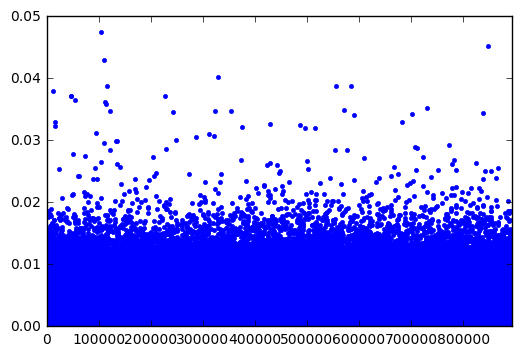

In [39]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

total['variance'].plot(style='.')

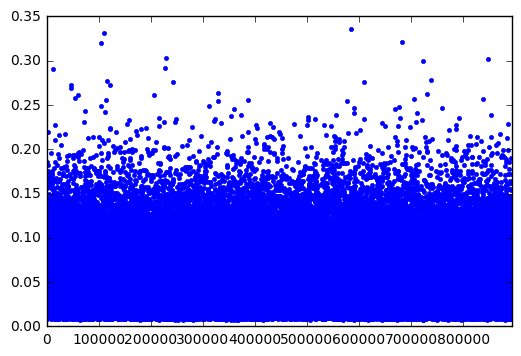

In [40]:
total['mean'].plot(style='.')